In [16]:
import os
import sys
import time
import numpy as np
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.measure
import plyfile
from plyfile import PlyData
from sklearn.neighbors import KDTree
import trimesh
import torch_geometric
from torch_geometric.nn import (NNConv, GMMConv, GraphConv, Set2Set)
from torch_geometric.nn import (SplineConv, graclus, max_pool, max_pool_x, global_mean_pool)
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [27]:
!nvidia-smi

Tue Aug 25 14:26:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   21C    P8     7W / 250W |  11378MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   29C    P8     8W / 250W |    583MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [17]:
def load_pressure_predictor(load_directory):
    model = SplineCNN8Residuals(3)
    model.load_state_dict(torch.load(load_directory + "/cfdModel.nn"))
    model = model.to("cuda:0").eval()
    return model

def load_latent_vectors(load_directory, checkpoint):
    filename = os.path.join(
        load_directory, checkpoint + ".pth"
    )
    if not os.path.isfile(filename):
        raise Exception(
            "The experiment directory ({}) does not include a latent code file"
            + " for checkpoint '{}'".format(load_directory, checkpoint)
        )
    data = torch.load(filename)
    return data["latent_codes"].cuda()

def load_decoder(load_directory, checkpoint):
    specs_filename = os.path.join(load_directory, "specs.json")
    if not os.path.isfile(specs_filename):
        raise Exception(
            'The experiment directory does not include specifications file "specs.json"'
        )
    specs = json.load(open(specs_filename))
    latent_size = specs["CodeLength"]
    decoder = Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(os.path.join(load_directory, checkpoint +".pth"))
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    decoder = decoder.module.cuda()
    decoder.eval()
    return decoder

In [18]:
from abc import ABC, abstractmethod

class objective_func(ABC):
    @abstractmethod
    def func(self, x):
        pass
    def dfunc(self, x):
        out = self.func(x)
        out.backward()
        return x.grad
    def get_optimal(self):
        return self.optimal
    def get_optimum(self):
        return self.optimum
    

class Decoder(nn.Module):
    def __init__(
        self,
        latent_size,
        dims,
        dropout=None,
        dropout_prob=0.0,
        norm_layers=(),
        latent_in=(),
        weight_norm=False,
        xyz_in_all=None,
        use_tanh=False,
        latent_dropout=False,
    ):
        super(Decoder, self).__init__()

        def make_sequence():
            return []

        dims = [latent_size + 3] + dims + [1]

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.latent_dropout = latent_dropout
        if self.latent_dropout:
            self.lat_dp = nn.Dropout(0.2)

        self.xyz_in_all = xyz_in_all
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xyz_in_all and layer != self.num_layers - 2:
                    out_dim -= 3

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

            if (
                (not weight_norm)
                and self.norm_layers is not None
                and layer in self.norm_layers
            ):
                setattr(self, "bn" + str(layer), nn.LayerNorm(out_dim))

        self.use_tanh = use_tanh
        if use_tanh:
            self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    # input: N x (L+3)
    def forward(self, input):
        xyz = input[:, -3:]

        if input.shape[1] > 3 and self.latent_dropout:
            latent_vecs = input[:, :-3]
            latent_vecs = F.dropout(latent_vecs, p=0.2, training=self.training)
            x = torch.cat([latent_vecs, xyz], 1)
        else:
            x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
            elif layer != 0 and self.xyz_in_all:
                x = torch.cat([x, xyz], 1)
            x = lin(x)
            # last layer Tanh
            if layer == self.num_layers - 2 and self.use_tanh:
                x = self.tanh(x)
            if layer < self.num_layers - 2:
                if (
                    self.norm_layers is not None
                    and layer in self.norm_layers
                    and not self.weight_norm
                ):
                    bn = getattr(self, "bn" + str(layer))
                    x = bn(x)
                x = self.relu(x)
                if self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return x
class SplineBlock(nn.Module):
    def __init__(self, num_in_features, num_outp_features, mid_features, kernel=3, dim=3, batchnorm1=True):
        super(SplineBlock, self).__init__()
        self.batchnorm1 = batchnorm1
        self.conv1 = SplineConv(num_in_features, mid_features, dim, kernel, is_open_spline=False)
        if self.batchnorm1:
            self.batchnorm1 = torch.nn.BatchNorm1d(mid_features)
        self.conv2 = SplineConv(mid_features, 2 * mid_features, dim, kernel, is_open_spline=False)
        self.batchnorm2 = torch.nn.BatchNorm1d(2 * mid_features)
        self.conv3 = SplineConv(2 * mid_features + 3, num_outp_features, dim, kernel, is_open_spline=False)
  
    def forward(self, res, data):
        if self.batchnorm1:
            res = F.elu(self.batchnorm1(self.conv1(res, data['edge_index'], data['edge_attr'])))
        else:
            res = F.elu(self.conv1(res, data['edge_index'], data['edge_attr']))
        res = F.elu(self.batchnorm2(self.conv2(res, data['edge_index'], data['edge_attr'])))
#         res = F.elu(self.conv2(res, data.edge_index, data.edge_attr))
        res = torch.cat([res, data['x']], dim=1)
        res = self.conv3(res, data['edge_index'], data['edge_attr'])
        return res

class SplineCNN8Residuals(nn.Module):
    def __init__(self, num_features, kernel=3, dim=3):
        super(SplineCNN8Residuals, self).__init__()
        self.block1 = SplineBlock(num_features, 16, 8, kernel, dim)
        self.block2 = SplineBlock(16, 64, 32, kernel, dim)
        self.block3 = SplineBlock(64, 64, 128, kernel, dim)
        self.block4 = SplineBlock(64, 8, 16, kernel, dim)
        self.block5 = SplineBlock(11, 32, 16, kernel, dim)
        self.block6 = SplineBlock(32, 64, 32, kernel, dim)
        self.block7 = SplineBlock(64, 64, 128, kernel, dim)
        self.block8 = SplineBlock(75, 4, 16, kernel, dim)

    def forward(self, data):
        res = data['x']
        res = self.block1(res, data)
        res = self.block2(res, data)
        res = self.block3(res, data)
        res4 = self.block4(res, data)
        res = torch.cat([res4, data['x']], dim=1)
        res = self.block5(res, data)
        res = self.block6(res, data)
        res = self.block7(res, data)
        res = torch.cat([res, res4, data['x']], dim=1)
        res = self.block8(res, data)
        return res

def create_mesh(
    decoder, latent_vec, filename='', N=256, max_batch=32 ** 3, offset=None, scale=None
):
    ply_filename = filename

    decoder.eval()

    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = [-1, -1, -1]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
    samples = torch.zeros(N ** 3, 4)

    # transform first 3 columns
    # to be the x, y, z index
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() // N) % N
    samples[:, 0] = ((overall_index.long() // N) // N) % N

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3

    samples.requires_grad = False
    head = 0

    while head < num_samples:
        sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda()
        num_subsample = min(max_batch, num_samples-head)
        latent_repeat = latent_vec.expand(num_subsample, -1)
        inputs = torch.cat([latent_repeat, sample_subset], 1)
        samples[head : min(head + max_batch, num_samples), 3] = \
                decoder(inputs).squeeze(1).detach().cpu()
        head += max_batch
        
    sdf_values = samples[:, 3].reshape(N, N, N).data.cpu()

    return convert_sdf_samples_to_ply(
        sdf_values,
        voxel_origin,
        voxel_size,
        ply_filename + ".ply",
        offset,
        scale,
    )

def convert_sdf_samples_to_ply(
    pytorch_3d_sdf_tensor,
    voxel_grid_origin,
    voxel_size,
    ply_filename_out,
    offset=None,
    scale=None,
):
    """
    Convert sdf samples to .ply

    :param pytorch_3d_sdf_tensor: a torch.FloatTensor of shape (n,n,n)
    :voxel_grid_origin: a list of three floats: the bottom, left, down origin of the voxel grid
    :voxel_size: float, the size of the voxels
    :ply_filename_out: string, path of the filename to save to

    This function adapted from: https://github.com/RobotLocomotion/spartan
    """

    numpy_3d_sdf_tensor = pytorch_3d_sdf_tensor.numpy()

    verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(
        numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3
    )

    # transform from voxel coordinates to camera coordinates
    # note x and y are flipped in the output of marching_cubes
    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

    # apply additional offset and scale
    if scale is not None:
        mesh_points = mesh_points / scale
    if offset is not None:
        mesh_points = mesh_points - offset

    # try writing to the ply file

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])
    norms_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(mesh_points[i, :])
        norms_tuple[i] = tuple(normals[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")
    el_norms = plyfile.PlyElement.describe(norms_tuple, "normals")

    ply_data = plyfile.PlyData([el_verts, el_faces, el_norms])
    return ply_data

def compute_lift_faces_diff(mesh, preds):
    pressures = torch.mean(preds[mesh['face'], 0], axis=0)

    # TODO: cahnge to x if needed
    pos = mesh['x']
    cross_prod = (pos[mesh['face'][1]] - pos[mesh['face'][0]]).cross(
                  pos[mesh['face'][2]] - pos[mesh['face'][0]])
    area = -cross_prod[:, 0] / 2
    lift = torch.mul(pressures, area)
    return torch.sum(lift[~torch.isnan(lift)])

def boundsLoss(points, box=[(-1, 1, 0)]):
    loss = 0
    for l, r, i in box:
        loss +=  torch.mean(F.relu(-points[:, i] + l))  \
               + torch.mean(F.relu( points[:, i] - r))
    return loss

def innerBoundsLoss(points, r=1, center=(0, 0, 0)):
    radiuses = torch.sum( (points - torch.Tensor(center).to('cuda:0')) ** 2 , dim=1)
    return torch.mean(F.relu(r - radiuses))

def calculate_loss(mesh, local_preds, constraint_rad=0.1):
    loss = compute_lift_faces_diff(mesh, local_preds)
    first = loss.clone().detach().cpu().numpy()
    loss += boundsLoss(mesh['x'], box=[(-0.6, 0.6, 0)])
    second = loss.clone().detach().cpu().numpy()
    loss += innerBoundsLoss(mesh['x'], r=constraint_rad**2, center=(-0.05, 0.05, 0))  \
          + innerBoundsLoss(mesh['x'], r=(constraint_rad / 2)**2, center=(0.3, 0, 0))
    print("three parts (321) of loss: %.3f, %.3f, %.6f"%(loss.detach().cpu().numpy() - second, second-first, first))
    return loss

def transformPoints(points, AvgTransform):
    matrix = torch.cuda.FloatTensor(AvgTransform)
    column = torch.zeros((len(points), 1), device="cuda:0") + 1
    stacked = torch.cat([points, column], dim=1)
    transformed = torch.matmul(matrix, stacked.t()).t()[:, :3]
    return transformed

def transform_mesh(points, ply_mesh, AvgTransform):
    transformed_points = transformPoints(points, AvgTransform)
    
    edges = trimesh.geometry.faces_to_edges(ply_mesh['face']['vertex_indices'])
    np_points = transformed_points.cpu().detach().numpy()
    edge_attr = [np_points[a] - np_points[b] for a, b in edges]
    mesh = {'x': transformed_points, 
        'face':torch.tensor(ply_mesh['face']['vertex_indices'], dtype=torch.long).to('cuda:0').t(),
        'edge_attr':torch.tensor(edge_attr, dtype=torch.float).to('cuda:0'),
        'edge_index':torch.tensor(edges, dtype=torch.long).t().contiguous().to('cuda:0')
        }
    return mesh


def decode_sdf(decoder, latent_vector, queries):
    num_samples = queries.shape[0]

    if latent_vector is None:
        inputs = queries
    else:
        latent_repeat = latent_vector.expand(num_samples, -1)
        inputs = torch.cat([latent_repeat, queries], 1)

    sdf = decoder(inputs)

    return sdf
class single_experiment:
    def __init__(self, tol=0.1):
        self.tol = tol
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        dist_arg = np.linalg.norm(optimal.detach().cpu().numpy() - self.objective_func.get_optimal())
        dist_val = np.linalg.norm(optimum.detach().cpu().numpy() - self.objective_func.get_optimum())
        if  dist_arg < self.tol \
        or  dist_val < self.tol:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
        print("distance domain, codomain: ", dist_arg, dist_val)
        if self.optimizer.verbose:
            print("Result: ", statistics['status'])
            print("found minimum: {}, minimum position: {}, evals: {}".format(optimum, torch.norm(optimal).item(), statistics['evals']))
        if self.optimizer.record == False:
            return statistics['status'], optimum, optimal, statistics['evals']
        else:
            statistics['optimal'] = self.objective_func.get_optimal()
            statistics['optimum'] = self.objective_func.get_optimum()
            statistics['found_optimal'] = optimal
            statistics['found_optimum'] = optimum
            return statistics
            

def get_trimesh_from_torch_geo_with_colors(mesh, preds, vmin=-8, vmax=8):
    norm = mpl.colors.Normalize(vmin= vmin, vmax=vmax)
    cmap = cm.hot
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    verticies = mesh['x'].cpu().detach()
    faces = mesh['face'].t().cpu().detach()
    return trimesh.Trimesh(vertices=verticies, faces=faces, 
                           vertex_colors=list(map(lambda c: m.to_rgba(c),  preds[:, 0].cpu().detach())))



In [4]:
DIR_to_load_data = 'starting_data'
experiment_directory = "data_for_this_experiments"

predictor = load_pressure_predictor(DIR_to_load_data)

decoder = load_decoder(DIR_to_load_data, "decoderModel")

latent_vectors = load_latent_vectors(DIR_to_load_data, "latentCodes").detach()

AvgTransform = np.load(DIR_to_load_data + "/avg_trans_matrix.npy") #computeAvgTransform()

LATENT_TO_OPTIMIZE = latent_vectors[32]
LATENT_KD_TREE = KDTree(np.array([lv.cpu().detach().numpy()[0] for lv in latent_vectors]))
# /cvlabdata2/home/artem/Data/cars_remeshed_dsdf/transforms/"

In [5]:
def visual_Mesh(ilatent, N):
    with torch.no_grad():
        ply_mesh = create_mesh(decoder,
                            ilatent,
                            N=N,
                            max_batch=int(2 ** 18))
        points = torch.cuda.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                            ply_mesh['vertex']['y'][:, None], 
                                            ply_mesh['vertex']['z'][:, None])))
        scaled_mesh = transform_mesh(points, ply_mesh, AvgTransform)
        pressure_field = predictor(scaled_mesh)
        loss = compute_lift_faces_diff(scaled_mesh, pressure_field)  
    print("latent loss. %f "%(loss))
    return get_trimesh_from_torch_geo_with_colors(scaled_mesh, pressure_field)

In [23]:
def method4_to_arbitatry_loss(points, ply_mesh, model, constraint_rad=0.1, axis=0):
    initial_dir = points.grad.clone()
    points.grad.data.zero_()
    #points.requires_grad_(False)
    mesh = transform_mesh(points, ply_mesh, AvgTransform)
    #mesh['x'] = mesh['x'].detach().requires_grad_(True)
    local_preds = model(mesh)
    loss = calculate_loss(mesh, local_preds, constraint_rad=constraint_rad)
    loss.backward()

    sign = [-p1.dot(p2) for p1, p2 in zip(initial_dir, points.grad)]
    
    return sign, loss, local_preds, mesh

def optimize_shape_deepSDF(decoder, latent, 
                           num_iters=100, num_neignours_constr=10,
                           lr=0.2, decreased_by=2, adjust_lr_every=10, alpha_penalty=0.05,
                           multiplier_func=method4_to_arbitatry_loss, verbose=None, save_to_dir=None, N=256, optimizer=None):

    def adjust_learning_rate(
        initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every
    ):
        lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every)) \
                        * ((punch_lr_at_reindex_by) ** (num_iterations // reindex_latent_each))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        return lr
    
    #ref_latent = latent.clone().detach()
    decoder.eval()
    latent = latent.clone().detach()
    optimizer.init(latent)
    latent = optimizer.step(0, latent, None, None)
    print("\n")
    phy_loss_plot = []
    penalty_plot = []
    latent_plot = []
    math_loss_plot = []
    for i in range(1, num_iters):
        start = time.time()
        
        #cur_rl = adjust_learning_rate(lr, inner_opt, i, decreased_by, adjust_lr_every)
        latent = latent.detach().reshape(1,-1).requires_grad_(True)
        #print("initial loss: ", func(latent))
    
        try:
            with torch.no_grad():
                ply_mesh = create_mesh( decoder,
                                        latent,
                                        N=N,
                                        max_batch=int(2 ** 18),
                                        offset=None,
                                        scale=None)
        except e:
            print("out of space", e)
            continue
            
        end = time.time()
        print("mesh time: %.1f "%(end-start))

        points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                                    ply_mesh['vertex']['y'][:, None], 
                                                    ply_mesh['vertex']['z'][:, None]))).cuda(0)
        
        points.requires_grad = True

        sdf_value = decode_sdf(decoder, latent.detach(), points)
        sdf_value.backward(torch.ones([len(points), 1], dtype=torch.float32).cuda(0))

        
        mults, loss_value, preds, transformed_mesh = multiplier_func(points, ply_mesh)         
        multipliers = torch.cuda.FloatTensor(mults).cuda(0)
    
        sdf_value = torch.squeeze(decode_sdf(decoder, latent, points.detach()))
    
        final_loss = torch.sum(sdf_value * multipliers)
        
        
        final_loss.backward()
        #first_deri = torch.norm(latent.grad).item()
        #first_d = latent.grad.clone().squeeze()
        
        
        # Soft-constraints
        distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach().reshape(1,-1), k=num_neignours_constr)
        apenalty = alpha_penalty * torch.sum((latent.reshape(1,-1) - latent_vectors[indeces.squeeze()]) ** 2, dim=2).mean()

        apenalty.backward()
        sum_d = latent.grad.squeeze()
        #second_d = sum_d - first_d
        #second_deri = torch.norm(second_d).item()

    
        math_loss = apenalty
        

        latent = optimizer.step(i, latent, math_loss, sum_d)
        
        end_end = time.time()
        
        print("backward time: %.2f"%(end_end-start))
        

        math_loss_plot.append(math_loss.item())
        penalty_plot.append(apenalty)
        phy_loss_plot.append(loss_value.item())
        latent_plot.append(latent.detach().cpu().numpy())
        np.save(os.path.join(save_to_dir, "phy_loss_plot.npy"), phy_loss_plot)    
        np.save(os.path.join(save_to_dir, "latent_series.npy"), latent_plot)    
        np.save(os.path.join(save_to_dir, "math_loss_plot.npy"), math_loss_plot)   
        
        if verbose is not None and i % verbose == 0:
            print('Iter ', i)
            #print("gradient: first %.3f second %.3f, full %.3f, angle %.2f "%(first_deri, second_deri, \
            #    torch.norm(sum_d), 90 / np.pi * torch.acos(first_d.dot(second_d) / torch.norm(first_d)/torch.norm(second_d))))
            print('phys Loss: %.5f'%(loss_value.item()*1e4))
            #print("x: ", x0.detach().cpu().numpy())
            print("math loss: ", math_loss.item()*1e4)
            print("arti loss:", final_loss.item()*1e4)
            print('apenality: %f'%(apenalty.item()*1e4))
        print("\n")
        #if i > 2 and np.abs(loss_plot[-1] - loss_plot[-2]) < 1e-4:
            #print("one time of low progress!")
            #break
        
    return phy_loss_plot, math_loss_plot, penalty_plot, latent_plot



def make_full_transformation(initial_latent, experiment_name, N, verbose, adjust_lr_every, decreased_by, lr,
                             decoder, model, optimizer= None, alpha_penalty=0.05, constraint_rad=0.1, num_iters=200):
    '''
    kwargs:
        num_iters=1000, 
        adjust_lr_every=10, 
        decreased_by=1.2,
        lr=0.005
        verbose=10,
    '''

    #ref_points = get_points_from_latent(decoder, ref_latent, N=128)
    save_to_dir = experiment_name
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)

    #np.save(os.path.join(save_to_dir, "target_verts.npy"), ref_points)

    return optimize_shape_deepSDF(decoder=decoder, latent=initial_latent, N=N, num_iters=num_iters, optimizer=optimizer, 
                                  multiplier_func=lambda x, y: 
                                        method4_to_arbitatry_loss(x, y, model, 
                            constraint_rad=constraint_rad, axis=0),
                                           alpha_penalty=alpha_penalty,
                                           save_to_dir=save_to_dir, verbose=verbose)
   
    

In [24]:
class line_search():
    def __init__(self, alpha=1, beta=0.1):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = 100
        self.tol = 1e-2
        self.verbose = False
        self.record = False
        self.TAO = 0.5
        self.pre_x = None
     
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0']
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
        self.record = True if 'record' not in paras.keys() else paras['record']
        
    def init(self, a, b):
        self.alpha_ = a
        self.BETA = b
        self.TAO = 0.5
        self.cycle = 15
        
    def step(self, i, x, val, grad):
        if(i % self.cycle != 1 ):
            print("compare: ", val.item() , " and  ", (self.pre_val + self.alpha_ * self.pre_grad2).item(), "p2", self.pre_grad2.item())
        if i % self.cycle == 1 or val < (self.pre_val + self.alpha_ * self.pre_grad2):
            #val.backward()
            print(i, "***********one time of hit")
            #print("xx, ", x, val)
            #grad = x.grad
            #print("!!!!!  new grad: ", grad.cpu().numpy().shape)
            self.pre_grad = -grad
            #print("grad", grad.squeeze()[:10], "p2 norm2: ", -torch.norm(grad)**2)
            self.pre_grad2 = -grad @ grad.t() * self.BETA
            self.pre_val = val 
            self.pre_x = x
            return x + self.alpha_ * -grad
        else:
            self.alpha_ *= self.TAO
            print(i, "<<<<<<<<<<<<<<<< miss! ",self.alpha_)
            #print("pre_x ", self.pre_x.detach().cpu().numpy())
            #print("alpha_ ", self.alpha_)
            #print("grad: ", self.pre_grad.detach().cpu().numpy())
            #print("multi: ", (self.alpha_*self.pre_grad).detach().cpu().numpy())
            return self.pre_x + self.alpha_*self.pre_grad

In [25]:
class cma_es():
    def __init__(self, dim=2):
        self.DIM = dim
        paras = {'x0': torch.zeros((dim,)),
                 'std': torch.ones((dim,)) * 3, 
                 'tol': 1e-5, 
                 'adjust_func': None, 
                 'record': False, 
                 'verbose': False}
        self.set_parameters(paras)
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0'] 
        self.std = paras['std']
        self.tol = paras['tol']
        self.adjust_func = paras['adjust_func']
        self.max_iter = 400 if 'max_iter' not in paras.keys() else paras['max_iter']
        # set none to use default value 
        self.cluster_size = None if 'cluster_size' not in paras.keys() else paras['cluster_size']
        self.survival_size = None if 'survival_size' not in paras.keys() else paras['survival_size']
        self.record = True if 'record' not in paras.keys() else paras['record']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
    def update_mean(self, xs):
        #print("weigths: ", self.WEIGHTS)
        #print("xs:", xs)
        #WEIGHTS = torch.tensor([1.0, 0.0, 0.0]).cuda()
        #print("before: ", func(self.mean.reshape(1,-1)))
        #print("shape: ", self.WEIGHTS.shape, WEIGHTS.shape, xs.shape)

        mean = (torch.matmul(self.WEIGHTS.reshape(1,-1), xs)).reshape(self.DIM, 1)
        
        #print("after: ", func(mean.reshape(1,-1)))
        #print("best: ", func(xs[0,:]), "second: ", func(xs[1,:]), "third: ", func(xs[2,:]))
        return mean
    def update_ps(self):
        return (1 - self.CS) * self.ps + torch.sqrt(self.CS * (2 - self.CS) * self.MUEFF) \
    * self.invsqrtC @ (self.mean - self.mean_old) / self.sigma 
    def update_pc(self, iter_):
        hsig = (torch.norm(self.ps) / torch.sqrt(1 - (1 - self.CS)**    \
        (2 * iter_/self.LAMBDA_)) / self.chiN < 1.4 + 2/(self.DIM + 1)).int()
        return (1 - self.CC) * self.pc + hsig * torch.sqrt(self.CC * (2 - self.CC) * \
                        self.MUEFF) * (self.mean - self.mean_old) / self.sigma
    def update_C(self, iter_, xs):
        hsig = (torch.norm(self.ps) / torch.sqrt(1 - (1 - self.CS)**(2 * iter_/  \
                self.LAMBDA_)) / self.chiN < (1.4 + 2/(self.DIM + 1))).int()
        artmp = (1 / self.sigma) * (xs - self.mean_old.reshape(1, self.DIM))
        return (1 - self.C1 - self.CMU) * self.c + self.C1 *  \
                (self.pc * self.pc.transpose(1,0) + (1 - hsig) * self.CC * \
                (2 - self.CC) * self.c) + self.CMU * artmp.transpose(1,0) @  \
                torch.diag(self.WEIGHTS) @ artmp
    def update_sigma(self):
        return self.sigma * torch.exp((self.CS / self.DAMPS) * (torch.norm(self.ps)/ self.chiN - 1))

    def init(self, latent):
        latent = latent.squeeze()
        # User defined input parameters 
        #self.DIM = latent.shape[1]
        # the size of solutions group
        self.LAMBDA_ = 4 + int(3 * torch.log(torch.tensor(self.DIM * 1.0))) if self.cluster_size == None else self.cluster_size  
        # only best "mu" solutions are used to generate iterations
        self.MU = int(self.LAMBDA_ / 2) if self.survival_size == None else self.survival_size
        # used to combine best "mu" solutions                                               
        self.WEIGHTS = torch.log(torch.tensor(self.MU + 1/2)) - torch.log(torch.arange(self.MU, dtype=torch.float) + 1) 
        self.WEIGHTS = (self.WEIGHTS / torch.sum(self.WEIGHTS)).cuda()   
        #self.WEIGHTS = torch.tensor([1.0, 0.0, 0.0]).cuda()
        self.MUEFF = 1 / torch.sum(self.WEIGHTS**2) 

        # Strategy parameter setting: Adaptation
        # time constant for cumulation for C
        self.CC = (4 +self. MUEFF / self.DIM) / (self.DIM + 4 + 2 * self.MUEFF / self.DIM)  
        # t-const for cumulation for sigma control
        self.CS = (self.MUEFF + 2) / (self.DIM + self.MUEFF + 5)  
        # learning rate for rank-one update of C
        self.C1 = 2 / ((self.DIM + 1.3)**2 + self.MUEFF)    
        # and for rank-mu update
        self.CMU = min(1 - self.C1, 2 * (self.MUEFF - 2 + 1 / self.MUEFF) / ((self.DIM + 2)**2 + self.MUEFF))  
        # damping for sigma, usually close to 1  
        self.DAMPS = 1 + 2 * max(0, torch.sqrt((self.MUEFF - 1)/( self.DIM + 1)) - 1) + self.CS     
        self.chiN = self.DIM**0.5 * (1 - 1/(4 * self.DIM) + 1 / (21 * self.DIM**2))  

        
        self.sigma = 0.3
        self.d = self.std / self.sigma
        self.mean = latent.detach().reshape(self.DIM,1)
        # Initialize dynamic (internal) strategy parameters and constants
        # evolution paths for C and sigma
        self.pc = torch.zeros((self.DIM, 1), device=torch.device('cuda:0'))     
        self.ps = torch.zeros((self.DIM, 1), device=torch.device('cuda:0')) 
        # B defines the coordinate system
        self.b = torch.eye(int(self.DIM), device=torch.device('cuda:0'))       
        # covariance matrix C
        self.c = self.b * torch.diag(self.d**2) * self.b.transpose(1, 0)
        # C^-1/2 
        self.invsqrtC = self.b * torch.diag(self.d**-1) * self.b.transpose(1, 0)
        # expectation of ||N(0,I)|| == norm(randn(N,1)) 
        self.xs = []
        self.fs = []
        self.j = 0
        self.cycle = 5
        self.ls = line_search()
        self.ls.init(0.5, 0.01)
    def add_inner(self, ls):
        self.ls = ls
    def step(self, i, x, val, grad):
        if i % self.cycle != 0 :
            #print("before inner: ", x.detach().cpu().numpy())
            #print("before adam loss: ", func(x))
            opt = torch.optim.SGD([x], lr=0.2)
            opt.step()
            #print("after adam loss: ", func(x))
            #x = self.ls.step(i, x, val, grad)
            #print("What can I do? after inner: ", x.detach().cpu().numpy())
            return x.reshape(1,-1)
        elif i != 0:
            self.xs.append(x.detach().squeeze().clone())
            self.fs.append(val)
            #old = x.clone()
            #opt = torch.optim.SGD([x], lr=0.2)
            #opt.step()
            #return x
        if i % (self.cycle * self.LAMBDA_) == 0 and i != 0:
            #print("lenght: ", len(self.fs))
            idx = torch.argsort(torch.tensor(self.fs))
            x_ascending = torch.stack(self.xs)[idx]
            
            # update the parameter for next iteration
            self.mean_old = self.mean.clone()
            self.mean = self.update_mean(x_ascending[:self.MU])
            self.ps = self.update_ps()
            self.pc = self.update_pc(int(i/self.LAMBDA_))
            self.sigma = self.update_sigma()
            self.c = self.update_C(int(i/self.LAMBDA_), x_ascending[:self.MU])
            self.c = (torch.triu(self.c) + torch.triu(self.c, 1).transpose(1,0))
            self.d, self.b = torch.eig(self.c, eigenvectors=True)
            print("eig: ", self.d[:10, 0].detach().cpu().numpy())
            self.d = torch.sqrt(self.d[:,0])
            self.invsqrtC = self.b @ torch.diag(self.d**-1) @ self.b.transpose(1,0)
            self.xs = []
            self.fs = []
            self.j += 1
            print("********** %d th iter of CMA completed************"%(self.j))
        x_new = (self.mean + self.sigma * self.b @ torch.diag(self.d)  \
                 @ torch.randn(self.DIM, 1).cuda())
        '''
        print("new sampled position: ", x_new)
        print("should be mean 0:  ", (self.sigma * self.b @ torch.diag(self.d)  \
                 @ torch.randn(self.DIM, 1).cuda()).cpu().numpy().mean(), \
              (self.sigma * self.b @ torch.diag(self.d)  \
                 @ torch.randn(self.DIM, 1).cuda()).cpu().numpy()[:20])
        '''
        print("<<<<<<<<<<<<<<new sampled position")
        return x_new.reshape(1, self.DIM)

In [ ]:
LATENT_TO_OPTIMIZE = latent_vectors[32]
DIR_for_dump_data = './cam_sgd_large'
punch_lr_at_reindex_by=1
reindex_latent_each = 10000

#np.random.seed(101)
#torch.manual_seed(213)

optimizer = cma_es(dim=256)
optParas ={'x0': LATENT_TO_OPTIMIZE,
       'std': torch.ones((256,), device=torch.device('cuda:0')) * 0.08, 
       'tol': 1e-6, 
       'adjust_func': None, 
       'cluster_size': 5,
       'record': True, 
       'max_iter': 50,
       'verbose': True}
optimizer.set_parameters(optParas)
# latent_vectors[292]

%time resSGD_dif_loc = make_full_transformation(LATENT_TO_OPTIMIZE.detach(), \
                         experiment_name=DIR_for_dump_data, decoder=decoder, optimizer=optimizer, model=predictor, \
                         alpha_penalty=2, \
                         constraint_rad=0.05,  \
                         num_iters=500,  \
                         adjust_lr_every=20,  \
                         decreased_by=1.1,  \
                         lr=0.3,  \
                         verbose=1, \
                         N=256)

<<<<<<<<<<<<<<new sampled position


mesh time: 11.0 
three parts (321) of loss: 0.000, 0.000, 0.054546
backward time: 35.65
Iter  1
phys Loss: 545.45783
math loss:  39483.482837677
arti loss: 0.1049447018885985
apenality: 39483.482838


mesh time: 11.0 
three parts (321) of loss: 0.000, 0.000, 0.072036
backward time: 41.36
Iter  2
phys Loss: 720.35827
math loss:  4501.906931400299
arti loss: 0.10625335562508553
apenality: 4501.906931


mesh time: 11.1 
three parts (321) of loss: 0.000, 0.000, 0.058014
backward time: 42.75
Iter  3
phys Loss: 580.14132
math loss:  2433.1168830394745
arti loss: 0.11605152394622564
apenality: 2433.116883


mesh time: 11.1 
three parts (321) of loss: 0.000, 0.000, 0.059923
backward time: 43.45
Iter  4
phys Loss: 599.22542
math loss:  2243.4280812740326
arti loss: 0.16104277165140957
apenality: 2243.428081


mesh time: 11.1 
three parts (321) of loss: 0.000, 0.000, 0.059100
<<<<<<<<<<<<<<new sampled position
backward time: 43.24
Iter  5
phys Loss: 590.99562

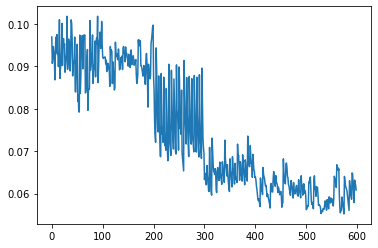

In [38]:
plt.plot(resCMASGD_20[0])

In [68]:
np.save('../Compare_optimisers/CMASGD_const_lr/full.npy', resSGD_dif_loc)

In [69]:
np.save('../Compare_optimisers/CMASGD_const_lr/phy_loss.npy', resSGD_dif_loc[0])

In [70]:
np.save('../Compare_optimisers/CMASGD_const_lr/math_loss.npy', resSGD_dif_loc[1])

In [71]:
np.save('../Compare_optimisers/CMASGD_const_lr/latent_series.npy', resSGD_dif_loc[3])

In [37]:
 4 + int(3 * torch.log(torch.tensor(256.0)))

20

In [60]:
#resCMASGD_20[0]

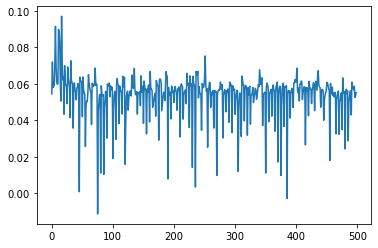

In [28]:
plt.plot(resSGD_dif_loc[0])

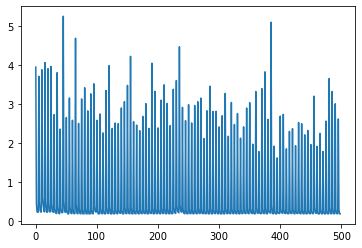

In [29]:
plt.plot(resSGD_dif_loc[1])

In [32]:
#lat = np.load("cma_sgd_20/latent_series.npy")
#aa = visual_Mesh(torch.tensor(lat[130]).cuda(), 256)
#aa.show()  #latent loss. 0.039726 

In [33]:
#aa = visual_Mesh(torch.tensor(resSGD_dif_loc[3][-2]).cuda(), 256)
#aa.show()

In [ ]:
latent loss. -0.015242 

In [31]:
#aa = visual_Mesh(torch.tensor(resSGD_dif_loc[3][1]).cuda(), 256)
#aa.show()  latent loss. -0.016967 

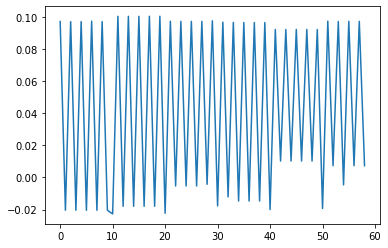

In [22]:
a = np.load("cma_sgd_cont/phy_loss_plot.npy")
plt.plot(a)

In [98]:
xx = np.stack(resCMA[3])

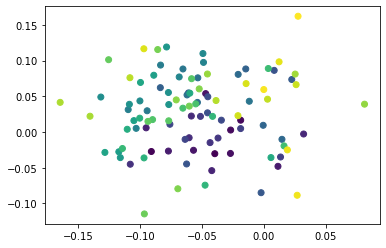

In [314]:
plt.scatter(x=xx[:,0,0], y=xx[:,0,1], c=np.arange(xx.shape[0]))

In [269]:
def func(latent):
    distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach().reshape(1,-1), k=10)
    return 0.2 * torch.sum((latent - latent_vectors[indeces.squeeze()]) ** 2, dim=2).mean()

print(func(LATENT_TO_OPTIMIZE))

mm = latent_vectors[Dindeces.squeeze()].sum(dim=0)/9
func(mm)

tensor(0.0797, device='cuda:0')


tensor(0.0280, device='cuda:0')

In [321]:
lat_cma = np.load("../Compare_optimisers/CMA/latent_series.npy")

In [322]:
func(torch.tensor(lat_cma[-1]).cuda())

tensor(3.1152, device='cuda:0')

In [323]:
math_loss_cma = np.load("../Compare_optimisers/CMA/math_loss.npy")

In [326]:
math_loss_cma = [func(torch.tensor(lat_cma[i]).cuda()) for i in range(lat_cma.shape[0])]

In [328]:
math_loss_cma = torch.stack(math_loss_cma).cpu().numpy()

In [331]:
np.save("../Compare_optimisers/CMA/math_loss_correct.npy" ,math_loss_cma)

In [320]:
mmmm = visual_Mesh(torch.tensor(resCMASGD_CONT[3][40]).cuda(), 256)
mmmm.show()

latent loss. 0.025287 


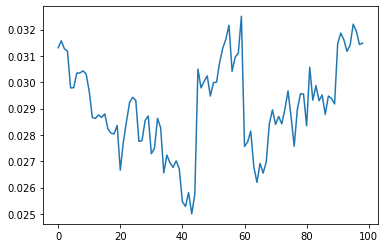

In [318]:
plt.plot(resCMASGD_CONT[0])

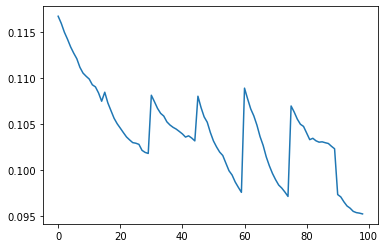

In [319]:
plt.plot(resCMASGD_CONT[1])

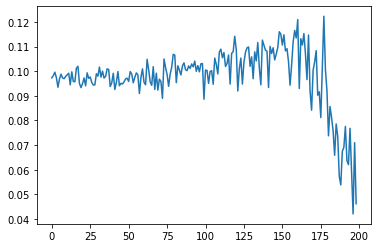

In [246]:
plt.plot(resCMA[0])

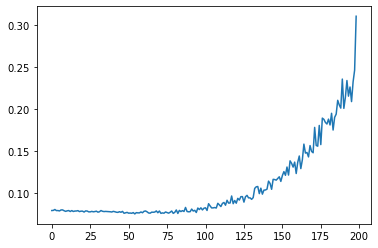

In [247]:
plt.plot(resCMA[1])

In [293]:
#resCMA[2]

In [200]:
math_loss = np.load('cma/math_loss_plot.npy', allow_pickle=True)

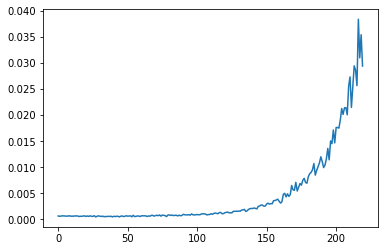

In [201]:
plt.plot(math_loss)

In [252]:
np.save("../Compare_optimisers/CMA/small_penality/phy_loss.npy", resCMA[0])

In [271]:
func(torch.tensor(resCMA[3][-3]).cuda())

tensor(0.2465, device='cuda:0')

In [277]:
#resCMA[0]

In [312]:
continue_cmasgd.shape

(1, 256)

In [310]:
continue_cmasgd = resCMASGD[3][-1]

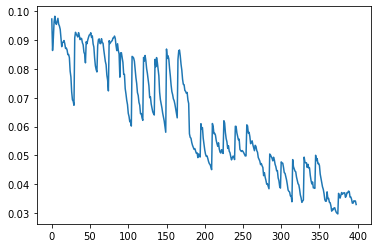

In [298]:
plt.plot(resCMASGD[0])

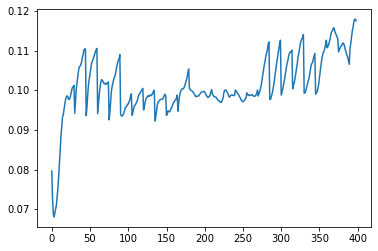

In [299]:
plt.plot(resCMASGD[1])

In [303]:
#msgd.export("../Compare_optimisers/CMASGD/mesh.ply")

In [305]:
sgdlat = np.load("../Compare_optimisers/SGD/latent_series.npy", allow_pickle=True)

In [308]:
sgdPhyL = np.load("../Compare_optimisers/SGD/phy_loss.npy")

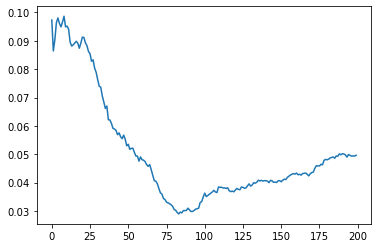

In [309]:
plt.plot(sgdPhyL)

In [307]:
sgdlat[-1]

tensor([[ 7.5822e-03, -1.2636e-02,  4.0583e-02,  3.1721e-02,  5.3537e-02,
          5.5812e-03,  9.3393e-03,  4.0941e-02,  5.6155e-03,  9.6364e-02,
         -7.7292e-03,  3.9413e-02, -2.9308e-02, -7.9693e-03,  6.4625e-02,
          6.4199e-03,  5.7653e-02, -7.8688e-02,  5.2377e-03,  1.1162e-01,
         -6.7229e-03,  8.3425e-04,  1.2631e-02, -4.5293e-02,  1.9046e-02,
          5.4943e-03,  2.5311e-02,  4.7163e-03, -1.2911e-02, -1.7805e-01,
          5.2651e-03,  2.9108e-02,  1.3436e-02,  3.1130e-02, -3.7081e-02,
          2.9674e-02,  2.1975e-02,  1.6737e-01, -2.7126e-02,  7.1742e-03,
          5.2538e-02, -5.1034e-03,  3.8904e-04,  4.8877e-02,  3.3296e-02,
         -1.7789e-02, -4.1387e-02,  3.6932e-03,  4.0146e-02, -2.2221e-02,
         -2.6848e-02, -4.8193e-03,  3.5962e-02, -8.8258e-02,  1.5906e-02,
         -4.4532e-02, -1.7593e-02,  5.0719e-02,  4.0455e-03,  5.1535e-02,
          2.9968e-02,  4.2621e-02, -6.5383e-03, -3.1548e-02,  9.9556e-03,
         -5.4266e-03, -1.1744e-02,  8.

In [ ]:
msgd = visual_Mesh(torch.tensor(resCMASGD[3][-2]).cuda(), 256)
#msgd.show()

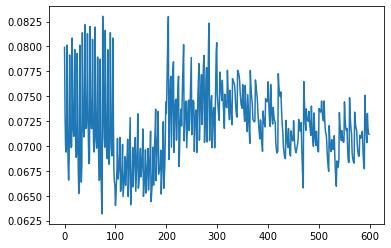

In [43]:
plt.plot(resCMASGD_20[1])

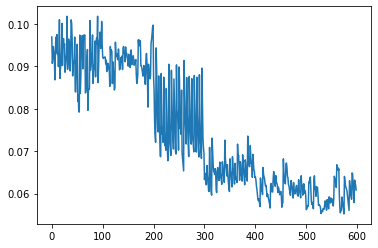

In [42]:
plt.plot(resCMASGD_20[0])

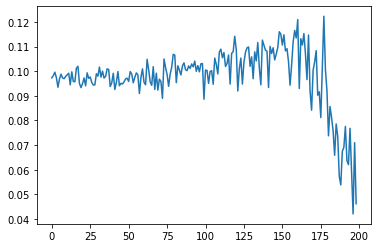

In [276]:
plt.plot(resCMASGD_20[0])

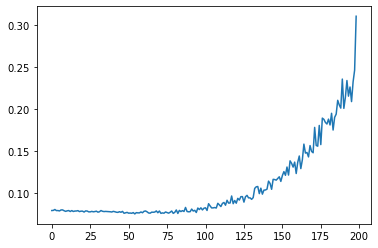

In [275]:
plt.plot(resCMA[1])

In [34]:
#mm = visual_Mesh(torch.tensor(resCMA[3][-4]).detach().cuda(), 256)
#mm.show()  # 2.5 h

In [292]:
#mm.export("../Compare_optimisers/CMA/small_penality/mesh.ply")

In [289]:
#math_loss

In [202]:
phy_loss = np.load('cma/phy_loss_plot.npy', allow_pickle=True)

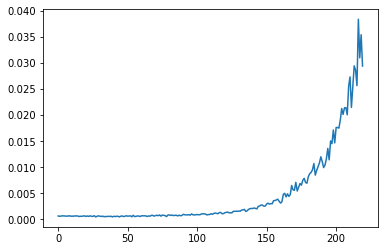

In [278]:
plt.plot(math_loss)

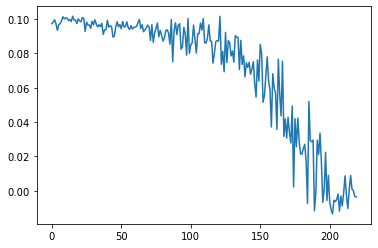

In [203]:
plt.plot(phy_loss)

In [288]:
#phy_loss

In [207]:
latents = np.load("cma/latent_series.npy", allow_pickle=True)

In [209]:
latents[0].shape

(1, 256)

In [211]:
latents.shape

(220, 1, 256)

In [214]:
func(torch.tensor(latents[-1]).cuda())

tensor(0.3115, device='cuda:0')

In [215]:
np.save("../Compare_optimisers/CMA/latent_series.npy", latents)

In [216]:
np.save("../Compare_optimisers/CMA/phy_loss.npy", phy_loss)

In [217]:
np.save("../Compare_optimisers/CMA/math_loss.npy", math_loss)

In [222]:
len(resCMA[1])

319

In [231]:
len(resCMA[3])

319

In [283]:
latents.shape

(220, 1, 256)

In [285]:
#torch.norm(torch.tensor(latents.squeeze()).cuda() - LATENT_TO_OPTIMIZE, dim=1)

tensor([0.0454, 0.0480, 0.0481, 0.0505, 0.0459, 0.0536, 0.0530, 0.0591, 0.0505,
        0.0596, 0.0744, 0.0776, 0.0735, 0.0777, 0.0770, 0.0753, 0.0751, 0.0940,
        0.0906, 0.0976, 0.0856, 0.0814, 0.0915, 0.1041, 0.0981, 0.1104, 0.1054,
        0.1049, 0.0938, 0.1117, 0.1129, 0.1035, 0.1235, 0.1130, 0.1208, 0.1389,
        0.1329, 0.1310, 0.1296, 0.1302, 0.1382, 0.1526, 0.1476, 0.1425, 0.1453,
        0.1435, 0.1336, 0.1401, 0.1703, 0.1565, 0.1676, 0.1561, 0.1589, 0.1847,
        0.1624, 0.1761, 0.1905, 0.1777, 0.1795, 0.1975, 0.1914, 0.1849, 0.1830,
        0.2020, 0.2026, 0.2215, 0.2174, 0.2236, 0.2142, 0.2345, 0.2198, 0.2493,
        0.2413, 0.2330, 0.2379, 0.2632, 0.2427, 0.2754, 0.2803, 0.2972, 0.2627,
        0.2699, 0.2671, 0.2829, 0.3128, 0.3063, 0.3156, 0.2863, 0.3039, 0.3728,
        0.3436, 0.3265, 0.3974, 0.3566, 0.3629, 0.4185, 0.4015, 0.3842, 0.3716,
        0.4236, 0.3895, 0.3962, 0.4313, 0.4278, 0.4357, 0.4386, 0.4430, 0.4492,
        0.4481, 0.4922, 0.4677, 0.4970, 

In [287]:
#m = visual_Mesh(torch.tensor(latents[150]).cuda(), 256)
#m.show()

In [241]:
#m.export("../Compare_optimisers/CMA/mesh.ply")